<a href="https://colab.research.google.com/github/jayanth142006/paddy-disease-classification/blob/main/paddy2(Xception).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os

In [ ]:
# Set the main directory containing subfolders of images
main_dir = "/content/drive/MyDrive/paddy"  # Change this to your main folder path
output_dir = "/content/drive/MyDrive/paddy2"  # Change this to your desired output directory
prefix = "image"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest"
)

# Loop through subfolders and images
print("[INFO] Processing images...")
for subdir, dirs, files in os.walk(main_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_path = os.path.join(subdir, file)
            rel_path = os.path.relpath(subdir, main_dir)
            save_subdir = os.path.join(output_dir, rel_path)
            os.makedirs(save_subdir, exist_ok=True)

            print(f"[INFO] Processing {image_path}...")
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)

            # Generate augmented images and save them
            total = 0
            imageGen = aug.flow(image, batch_size=1, save_to_dir=save_subdir,
                                 save_prefix=prefix, save_format="jpg")

            for img in imageGen:
                total += 1
                if total == 10:
                    break

print(f"[INFO] Augmented images saved in {output_dir}")

[INFO] Processing images...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2978.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2976.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2982.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2985.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2973.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2980.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2984.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2983.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2977.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2989.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2991.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2987.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_2988.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/blast/IMG_3002.jpg...
[INFO]

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = '/content/drive/MyDrive/paddy2'
img_size = (299, 299)
batch_size = 32
num_classes = 10 # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5134 images belonging to 10 classes.
Found 1278 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze All Convolutional Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 5091s 32s/step - accuracy: 0.3547 - loss: 1.6889 - val_accuracy: 0.7433 - val_loss: 0.7686
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6776 - loss: 0.8649 - val_accuracy: 0.8013 - val_loss: 0.5500
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7276 - loss: 0.7217 - val_accuracy: 0.8365 - val_loss: 0.4434
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7612 - loss: 0.6318 - val_accuracy: 0.8592 - val_loss: 0.3912
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7648 - loss: 0.6061 - val_accuracy: 0.8670 - val_loss: 0.3610
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7951 - loss: 0.5273 - val_accuracy: 0.8858 - val_loss: 0.3132
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8071 - loss: 0.4926 - val_accuracy: 0.8983 - val_loss: 0.2946
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8301 - loss: 0.4772 - val_ac

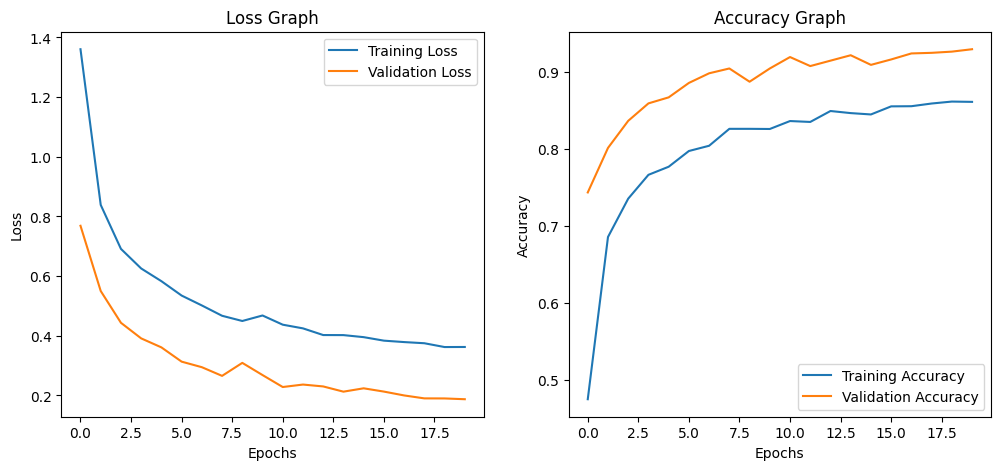

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step
Before Fine-Tuning:
                     precision    recall  f1-score   support

         False_smut       0.99      0.98      0.99       184
   bacterial_blight       0.98      0.96      0.97       260
              blast       0.98      0.88      0.93       189
          brownspot       0.85      0.77      0.81       190
grain_discoloration       0.96      1.00      0.98        27
              hispa       0.82      0.99      0.90       187
        leaf_streak       0.92      0.96      0.94        74
      sheath_blight       0.92      0.94      0.93        51
         sheath_rot       1.00      0.97      0.98        67
             tungro       0.96      1.00      0.98        49

           accuracy                           0.93      1278
          macro avg       0.94      0.95      0.94      1278
       weighted avg       0.93      0.93      0.93      1278



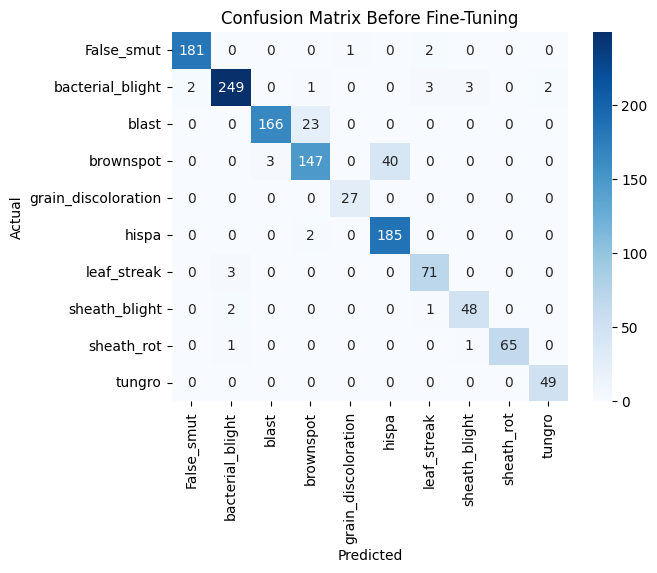

In [ ]:
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
# Fine-Tuning: Unfreeze layers from block10_sepconv1_act onward
for layer in base_model.layers[:86]:
    layer.trainable = False
for layer in base_model.layers[86:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.8177 - loss: 0.5397 - val_accuracy: 0.9491 - val_loss: 0.1326
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9079 - loss: 0.2527 - val_accuracy: 0.9710 - val_loss: 0.0919
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9404 - loss: 0.1681 - val_accuracy: 0.9750 - val_loss: 0.0775
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9492 - loss: 0.1275 - val_accuracy: 0.9718 - val_loss: 0.0710
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9570 - loss: 0.1151 - val_accuracy: 0.9797 - val_loss: 0.0496
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9772 - loss: 0.0788 - val_accuracy: 0.9844 - val_loss: 0.0444
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9713 - loss: 0.0853 - val_accuracy: 0.9836 - val_loss: 0.0462
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9754 - loss: 0.0668 - val_accu

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()